In [1]:
import numpy as np

num_points = 2000
vectors_set = []

# K-평균 예제를 실스하기 위해 샘플 데이터를 생성합니다.
# 두 개의 정규분포를 이용하여 2D 좌표계에 2000개의 점을 랜덤하게 생성하겠습니다.
for i in range(num_points):
    if np.random.random() > 0.5:
        vectors_set.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    else:
        vectors_set.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])

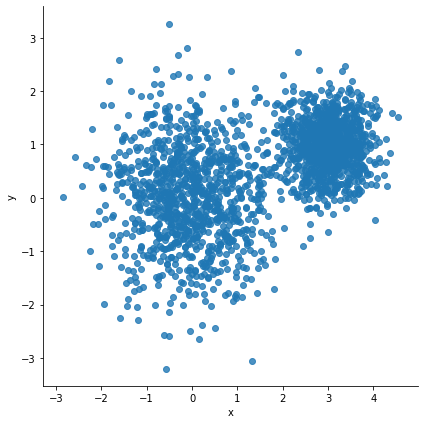

In [3]:
# 파이썬의 그래픽 라이브러리에서 matplotlib을 기반으로 하는 seaborn 시각화 패키지를 이용하겠습니다.
# 또한 좀 더 복잡한 형태의 데이터를 다루기 위해 데이터 조작 패키지 pandas를 사용하겠습니다.
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"x": [v[0] for v in vectors_set], "y": [v[1] for v in vectors_set]})
sns.lmplot("x", "y", data=df, fit_reg=False, height=6)
plt.show()

In [5]:
import tensorflow as tf

# 4개의 군집으로 그룹화하는 K-평균 알고리즘 구현 코드
# 모든 데이터를 텐서에 할당
vectors = tf.constant(vectors_set)
k = 4
# K개 임의좌표에 초기 중심 지정
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0,0],[k,-1]))
print(vectors.get_shape())
print(centroides.get_shape())

# 각 점(데이터)에 대해 유클리드 제곱 거리를 구해 가장 가까운 중심을 계산
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroides = tf.expand_dims(centroides, 1)

#assignments = tf.argmin(tf.reduce_sum(tf.square(tf.sub(sxpanded_vectors, expanded_centroides)), 2), 0)
# expaned_vectors와 expanded_centroids 뺄셈
diff = tf.subtract(expanded_vectors, expanded_centroides)
diff_sqr = tf.square(diff)
# 지정한 차원 축소
distances = tf.reduce_sum(diff_sqr, 2)
# 지정한 차원에서 가장 작은 값의 원소의 인덱스를 리턴
assignments = tf.argmin(distances)

means = tf.concat([tf.reduce_mean(tf.gather(vectors,
                                              tf.reshape(tf.where(tf.equal(assignments, c)), [1,-1])),
                                    reduction_indices=[1]) for c in range(k)],0)

update_centroides = tf.assign(centroides, means)

init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

for step in range(100):
    _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])

(2000, 2)
(4, 2)


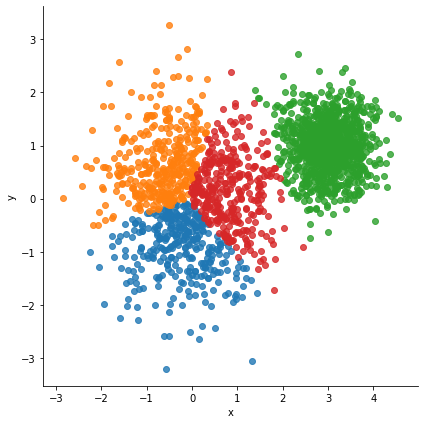

In [6]:
data={"x":[], "y":[], "cluster":[]}

for i in range(len(assignment_values)):
    data["x"].append(vectors_set[i][0])
    data["y"].append(vectors_set[i][1])
    data["cluster"].append(assignment_values[i])
    
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, height=6, hue="cluster", legend=False)
plt.show()